# Metropolitan City Crime Analysis

## City of Albuquerque
#### September 2018 to March 2019

### Data Information

In this project, the performance and predictive power of a model that has been trained and tested on data collected from Albuquerque police incident calls. 
A model trained on this data that is seen as a good fit could then be used to make certain predictions about crime in Albuquerque, New Mexico. This model may be useful for law enforcement to aid in data-driven decision making. 
The datasets for this project originates from The City of Albuquerque, New Mexico and The United States Census. 

**1. The City of Albuquerque**
This dataset represents the prior 180 rolling days of police incident calls and contains the block location, case number description and date of calls for service received by The Albuquerque Police Department. The incidents have been entered into the Computer Aided Dispatch (CAD) system and closed. This dataset contains 180 rolling days of incidents (September 2018 through March 2019). Accompanying the Incidents table is a codes table for describing each type of incident. No personally identifiable information (PII) is released. 

http://data.cabq.gov/publicsafety/policeincidents/


**2. The United States Census**
This 2013-2017 American Community Survey 5-Year Estimates dataset originates from The United States Census and contains demographic information per each census tract in Bernalillo County, New Mexico. Two tables were used in this project: Table S0101 - AGE AND SEX and S1903 - MEDIAN INCOME IN THE PAST 12 MONTHS (IN 2017 INFLATION-ADJUSTED DOLLARS). 

Table S0101 - AGE AND SEX and S1903:
https://factfinder.census.gov/faces/nav/jsf/pages/searchresults.xhtml?refresh=t

Table S1903 - MEDIAN INCOME IN THE PAST 12 MONTHS (IN 2017 INFLATION-ADJUSTED DOLLARS): 
https://factfinder.census.gov/faces/nav/jsf/pages/searchresults.xhtml?refresh=t


### Data Preprocessing
For the purposes of this project, the following preprocessing steps have been made to the dataset:

- Every incident included in the dataset had a [Pseudo-Mercator](https://epsg.io/3857) coordinate that was transformed into the [WGS84 ](https://epsg.io/4326) in order to align with geography points within the city of Albuquerque. 

- Each incident has been associated with a United States census tract, median age and median income. 

- Dates were originally provided in milliseconds and were transformed to a calendar date and time for ease of visualization. 

In [660]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Hiding the warnings
import warnings
warnings.filterwarnings('ignore')

# these libraraies are essential for rendering maps
from IPython.display import IFrame, display, HTML, Image


# Notebook display
%matplotlib inline

# Import supplementary visualizations code visuals.py
import visuals as vs

incidents= pd.read_csv('FINAL_MERGED_FILE_5_20_19.csv', low_memory=False)
crime_counts=pd.read_csv('CENSUS_CRIME_COUNTS.csv')

features = crime_counts[['MED_AGE','MED_INCOME']]
number_per_tract=crime_counts['COUNTS']

age=incidents['HC01_EST_VC37_x']
income=incidents['HC03_EST_VC02']

# view shape of dataset
print("Incidents dataset has {} data points with {} variables each.".format(*incidents.shape))

# Display the first record
display(incidents.head(n=1))

Incidents dataset has 28886 data points with 718 variables each.


,RECORDIDNUMBER,BlockAddress,State,IncidentType,Date_Milliseconds,Date_Time,Day_of_Week,Month,Day_of_Month,Year,...,HC02_EST_VC52,HC02_MOE_VC52,HC03_EST_VC52,HC03_MOE_VC52,HC01_EST_VC53,HC01_MOE_VC53,HC02_EST_VC53,HC02_MOE_VC53,HC03_EST_VC53,HC03_MOE_VC53
0,41625857,MONTGOMERY BL NE / EUBANK BL NE,NM,DISTURBANCE,1.540000e+12,10/22/2018 23:13,Monday,October,22,2018,...,23.3,9.7,46875,23476,13.0,12.0,5.9,5.2,-,**


### Data Exploration

In this section we would like to gain an understanding of the type of incidents contained within this dataset as well as the frequency. 

The purpose of this section is to provide initial investigation and to provide observations. 

The goal of this project is to develop a working model that has the ability to predict crime incidents in Albuquerque, the dataset will be separated into features and a target variable. 

The features are: '`MED_AGE`' (Median Age) and '`MED_INCOME`' (Median Income) will give useful information about each data point. The target variable, '`COUNTS`', will be the variable we seek to predict, which is the number of incidents per census tract.

#### Overall Investigation into data
This is done to provide a first glance at the data, for an initial view. The only columns in which statistics are helpful are  '`MED_AGE`' and '`MED_Income`'

In [661]:
crime_counts.describe()

,CENSUS_TRACT,MED_AGE,MED_INCOME,COUNTS,LONGITUDE,LATITUDE,LONG_CENSUS,CENSUS,STATE_ID
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,213.637933,38.962667,54470.280000,192.566667,-103.748722,35.128191,21363.793333,213.637933,75.500000
std,1317.718534,7.246740,23290.457153,198.275533,24.530972,0.055839,131771.853399,1317.718534,43.445368
min,1.070000,20.200000,18306.000000,1.000000,-106.753181,34.939182,107.000000,1.070000,1.000000
25%,7.047500,33.500000,37710.500000,54.250000,-106.665293,35.091717,704.750000,7.047500,38.250000
50%,34.505000,38.650000,48765.500000,124.500000,-106.582616,35.121983,3450.500000,34.505000,75.500000
75%,46.850000,42.975000,66326.500000,257.250000,-106.516961,35.169194,4685.000000,46.850000,112.750000
max,9407.000000,60.400000,140833.000000,941.000000,106.568750,35.248188,940700.000000,9407.000000,150.000000


#### Income and Age
In this particular section of exploration, we see that the majority of individuals are under the age of 55, with incomes less than $60,000 annually. 

The minimum age associated with this dataset is 20, and minimum income is $18,306 annually. The maximum age associated with our dataset is 60, and maximum income is over one hundred and forty thousand annually (140,000).   

In [662]:
#Income

# Minimum median income
min_med_income = np.min(income)

# Maximum median income
max_med_income = np.max(income)

# Mid point median income 
mid_med_income= (min_med_income + max_med_income  // 2)

# Standard deviation of median income 
std_med_income = np.std(income)

#Age

# Minimum median age
min_med_age= np.min(age)

# Maximum median age
max_med_age = np.max(age)

# Mid point median age
mid_med_age = (min_med_age + max_med_age  // 2)

# Standard deviation of median age
std_med_age = np.std(age)


# Show the calculated statistics
print("Statistics for Metropolitan City Crime Analysis:\n")
print("Minimum Median Income: ${}".format(min_med_income))
print("Minimum Median Age: {}".format(min_med_age))

print("Maximum Median Income: ${}".format(max_med_income))
print("Maximum Median Age: {}".format(max_med_age))

print("Mid-point of Median Income: ${}".format(mid_med_income))
print("Mid-point of Median Age: {}".format(mid_med_age))

print("Standard Deviation of Median Income: ${}".format(std_med_income))
print("Standard Deviation of Median Age: {}".format(std_med_age))

Statistics for Metropolitan City Crime Analysis:

Minimum Median Income: $18306.0
Minimum Median Age: 20.2
Maximum Median Income: $140833.0
Maximum Median Age: 60.4
Mid-point of Median Income: $88722.0
Mid-point of Median Age: 50.2
Standard Deviation of Median Income: $17945.913627339538
Standard Deviation of Median Age: 5.672234613036816


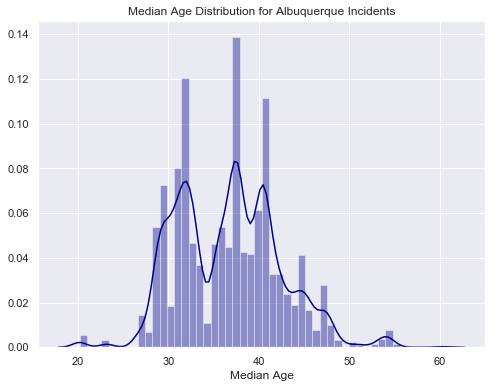

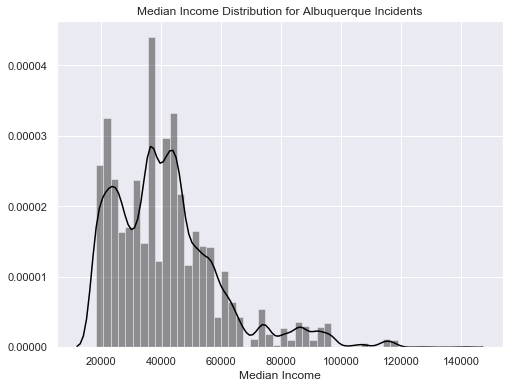

In [663]:
plt.figure(figsize=(8,6))
sns.distplot(incidents.HC01_EST_VC37_x.dropna(), color="darkblue")
plt.xlabel("Median Age")
plt.title("Median Age Distribution for Albuquerque Incidents") 
plt.show()

plt.figure(figsize=(8,6))
sns.distplot(incidents.HC03_EST_VC02.dropna(), color="black")
plt.xlabel("Median Income")
plt.title("Median Income Distribution for Albuquerque Incidents") 
plt.show()

#### Incidents

This dataset contains 49 unique incident types. The highest frequency of incident types are provided in a visualization below. 

In [664]:
#This is the unique count of Incident types contained within this dataset
unique_incidents=incidents.IncidentType.nunique()

print ("The Incidents dataset contains {} unique Incident Types.".format(unique_incidents))

The Incidents dataset contains 49 unique Incident Types.


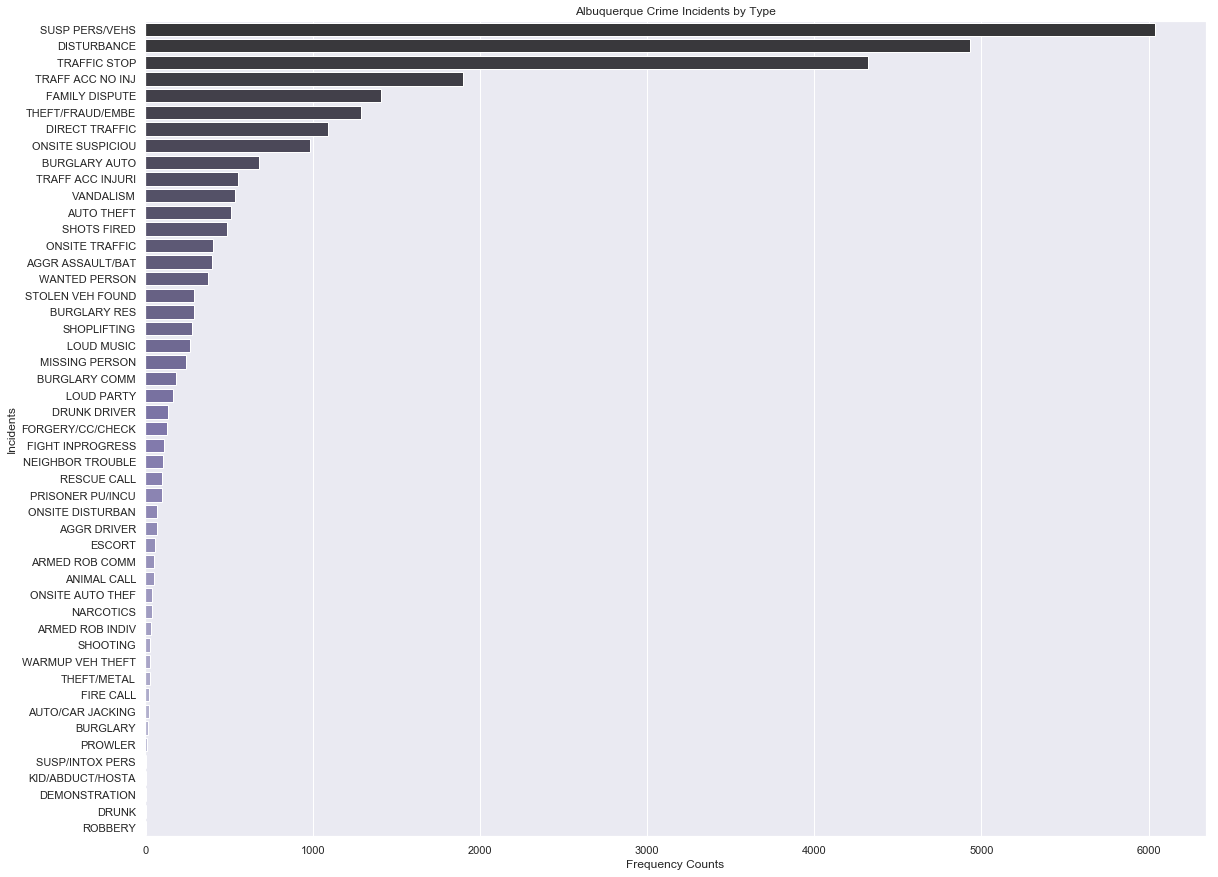

In [665]:
#Create graph to view frequency of incidents by incident type
sns.set(style="darkgrid", )
plt.figure(figsize=(19,15))
sns.countplot(y="IncidentType", data=incidents,
                 palette="Purples_d", order = incidents['IncidentType'].value_counts().index)
plt.xlabel("Frequency Counts")
plt.ylabel("Incidents")
plt.title("Albuquerque Crime Incidents by Type") 
plt.show()

In [666]:
incidents['IncidentType'].value_counts()

SUSP PERS/VEHS      6039
DISTURBANCE         4930
TRAFFIC STOP        4320
TRAFF ACC NO INJ    1902
FAMILY DISPUTE      1407
THEFT/FRAUD/EMBE    1292
DIRECT TRAFFIC      1093
ONSITE SUSPICIOU     983
BURGLARY AUTO        682
TRAFF ACC INJURI     554
VANDALISM            538
AUTO THEFT           514
SHOTS FIRED          490
ONSITE TRAFFIC       404
AGGR ASSAULT/BAT     398
WANTED PERSON        374
STOLEN VEH FOUND     290
BURGLARY RES         288
SHOPLIFTING          276
LOUD MUSIC           264
MISSING PERSON       240
BURGLARY COMM        184
LOUD PARTY           167
DRUNK DRIVER         133
FORGERY/CC/CHECK     130
FIGHT INPROGRESS     110
NEIGHBOR TROUBLE     105
RESCUE CALL           99
PRISONER PU/INCU      97
ONSITE DISTURBAN      72
AGGR DRIVER           69
ESCORT                57
ARMED ROB COMM        53
ANIMAL CALL           49
ONSITE AUTO THEF      42
NARCOTICS             40
ARMED ROB INDIV       33
SHOOTING              28
WARMUP VEH THEFT      27
THEFT/METAL           27


#### Year

When observing the overall incidents for the city of Albuquerque from October 2018 through March 2019, it appears that the number of incidents was far more frequent during the year of 2018. After looking into the data more, the number of incidents was significantly higher in October than in any other month within the time period. In 2018, incidents occurred frequently on Tuesdays, Wednesdays and Saturdays. In 2019, incidents occurred most frequently on Friday and Saturday. 

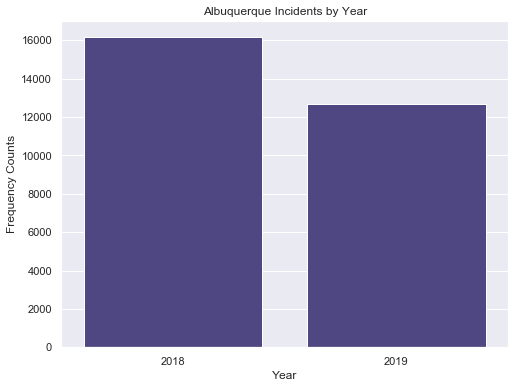

In [667]:
#Create a graph to view overall incidents by year
sns.set(style="darkgrid",)
plt.figure(figsize=(8,6))
sns.countplot(x="Year", color="darkslateblue", data=incidents)
plt.xlabel("Year")
plt.ylabel("Frequency Counts")
plt.title("Albuquerque Incidents by Year") 
plt.show()

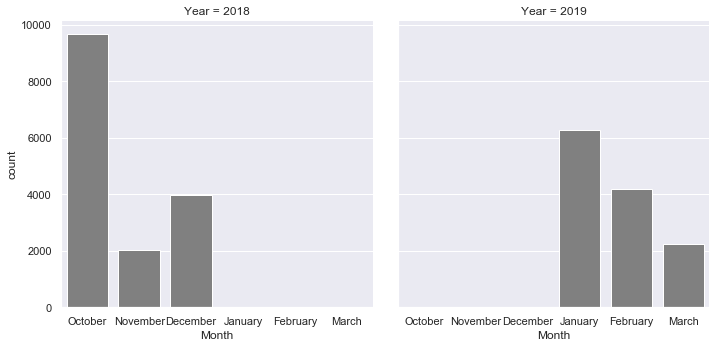

In [668]:
#Create a graph to view incidents by year and month
sns.set(style="darkgrid")
sns.catplot("Month", col="Year", data=incidents, kind="count",color="grey", order=["October", "November", "December", "January", "February", "March"]);

#### Month

As noted above, October 2018 had the highest number of incidents. When viewing incidents by type, the majority occurred in the month of October. The highest contributing incidents were Disturbance, Suspicious Persons and Traffic Stop. 

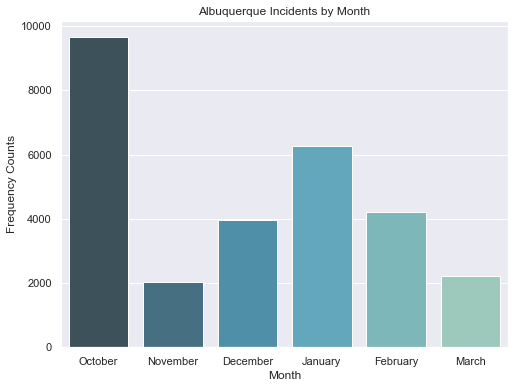

In [669]:
#Create graph to view incidents by month
sns.set(style="darkgrid",)
plt.figure(figsize=(8,6))
sns.countplot(x="Month", palette="GnBu_d", data=incidents, order=["October", "November", "December", "January", "February", "March"])
plt.xlabel("Month")
plt.ylabel("Frequency Counts")
plt.title("Albuquerque Incidents by Month") 
plt.show()

We would like to investigate what day in the month of October experienced the highest incidents. We suspect that the highest number of incidents occurred during Balloon Fiesta or Halloween. 

In [670]:
#Subset the Month of October into a dataframe
October=incidents[incidents['Month']=='October']

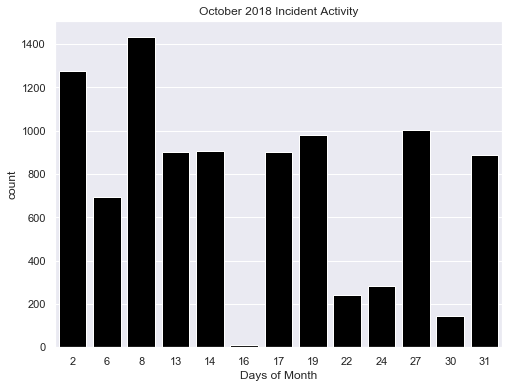

In [671]:
#Create a graph to view the days of acticity in October
plt.figure(figsize=(8,6))
sns.countplot(October.Day_of_Month, color="black")
plt.xlabel("Days of Month")
plt.title("October 2018 Incident Activity") 
plt.show()

This graph confirms the suspicion that the highest activities occurred during Tuesday, October 2nd 2018 and Monday, October 8th 2018. October 8th was a holiday (Columbus Day or Indigenous Day), and equated to a three day weekend for some individuals residing in Albuquerque. Also, October 8th was at the start of The International Balloon Fiesta. This event attracts tourists and visiting relatives. The factors that led to the increase in incidents on October 2nd is unknown at this time. We suspect perhaps there was an increase of individuals visiting town in preparation for the Balloon Fiesta at that time. 

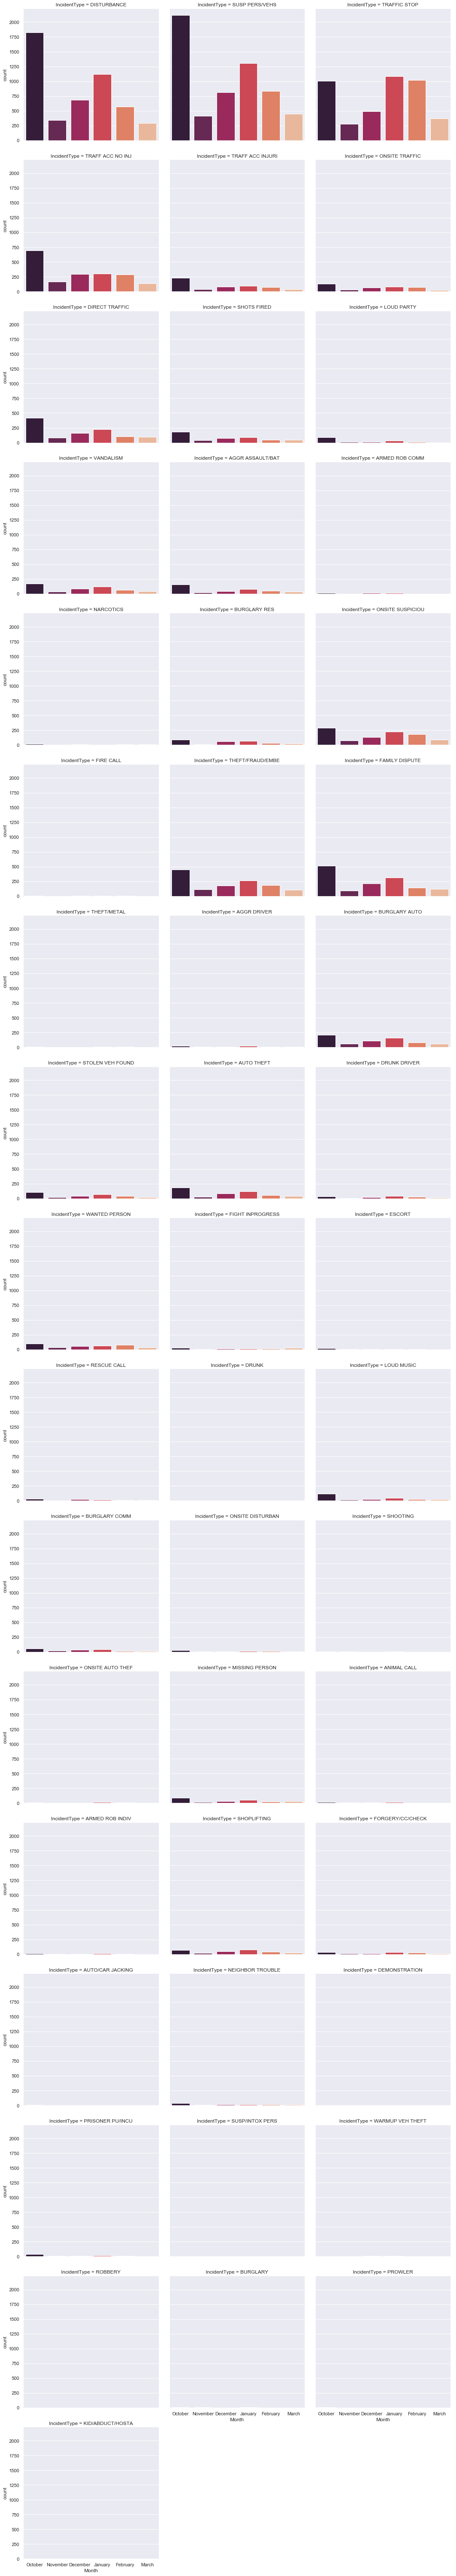

In [672]:
#Create graph to view incidents by type
sns.set(style="darkgrid")
sns.catplot("Month", col="IncidentType", data=incidents, palette= "rocket", kind="count",col_wrap=3, order=["October", "November", "December", "January", "February", "March"]);

#### Day of Week

These are the frequencies of incident types by days of week. The majority of incident types occur most frequently on the weekends. Interestingly enough, Incident Type-Traffic Accident without Injury, occurs during the week most likely during commutes to or from work. 

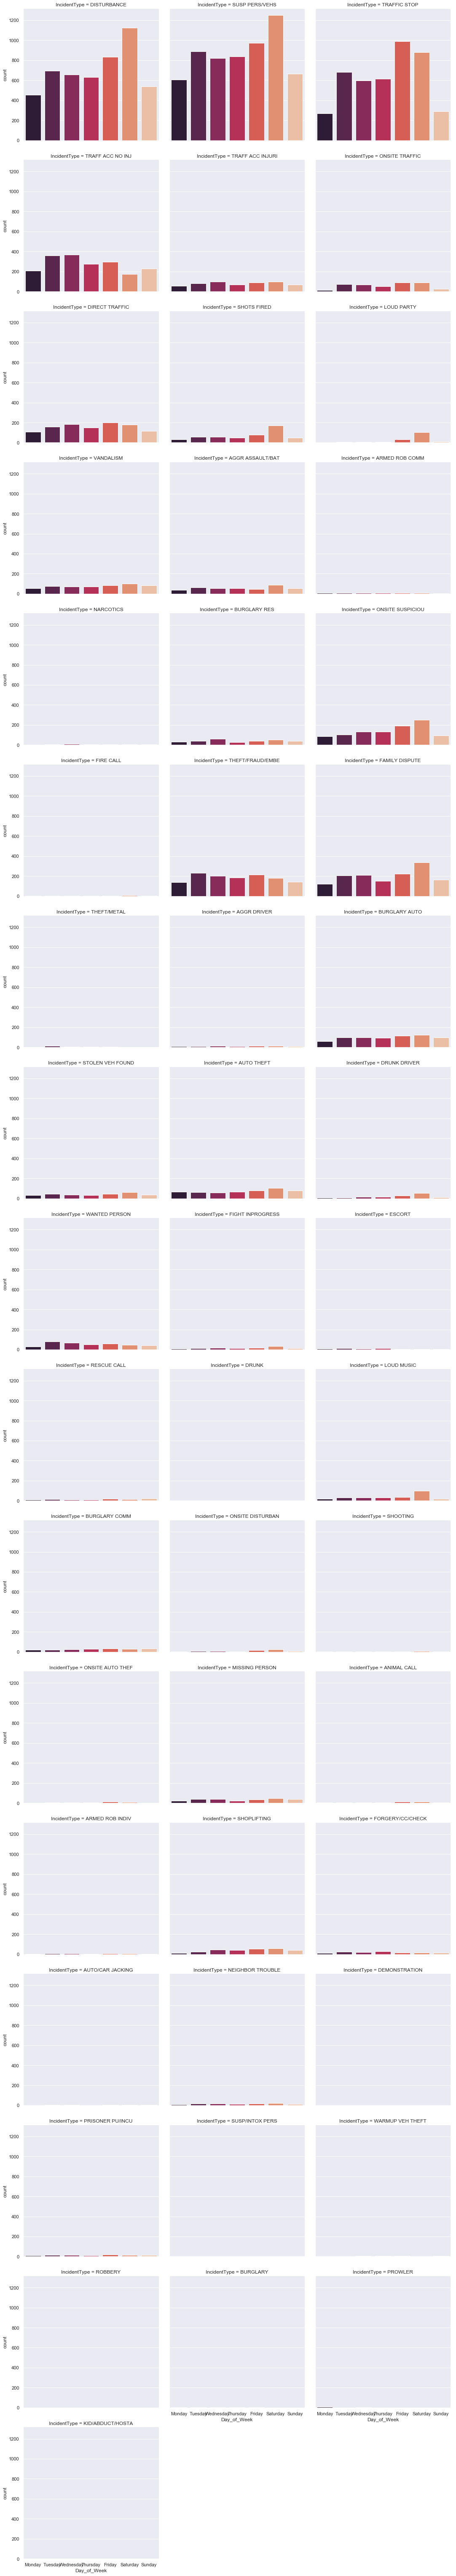

In [673]:
sns.set(style="darkgrid")
sns.catplot("Day_of_Week", col="IncidentType", data=incidents, palette="rocket", kind="count",col_wrap=3, order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]);


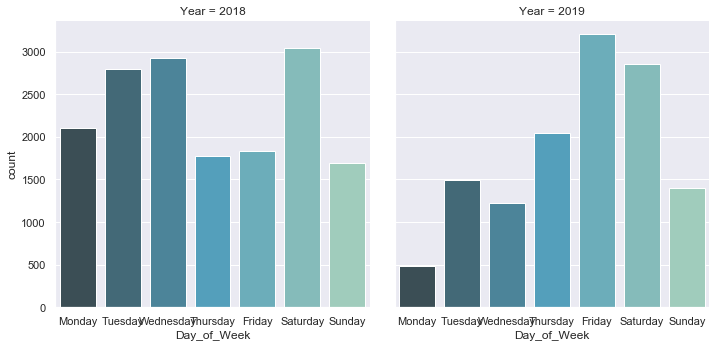

In [674]:
#Create a graph to view incidents by day of week and month
sns.set(style="darkgrid")
sns.catplot("Day_of_Week", col="Year", data=incidents, palette="GnBu_d", kind="count", order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]);


#### Census Tract Information

The city of Albuquerque is home to over 100 census tracts, and 37 zip codes. [Census tracts are statistical subdivisions designed to track residents created by The United States government. Census tracts became an official entity in 1940 for which The Census Bureau would collect and publish data for.](https://www2.census.gov/geo/pdfs/education/CensusTracts.pdf)

Below is census area map created by [The Albuquerque Journal in 2014](https://www.abqjournal.com/maps/census.html). The map below shows census areas that are shaded dependent upon median income and age. 

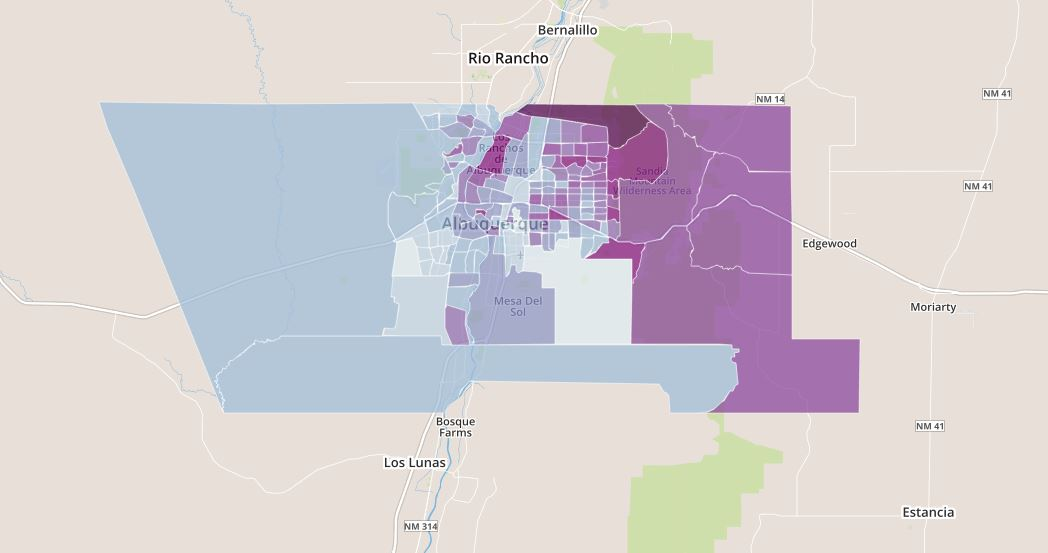

In [675]:
#Embed Census Tract Image
from IPython.display import Image
Image(filename='Census Areas Albuquerque.JPG')

The fifteen census tracts with the highest density of incidents are tabulated below along. Census tract 9.03 is located in SE Albuquerque in the Zuni and Gibson area. Census tract 6.03 is located between Lomas Blvd and Central Avenue. 

In [676]:
#unique census tracts in Albuquerque
census_tract_count=incidents['CENSUS_TRACT'].nunique()
#Census tracts incidents density
counts=crime_counts.sort_values('COUNTS', ascending=False)[:15]


print("There are a total of {} census tracts located within Albuquerque, New Mexico.".format(census_tract_count))
print ("The fifteen census areas with a higher frequency of incident calls are as follows:")
print(counts.to_string(col_space=15, max_cols=1, index=False, header=False))

There are a total of 151 census tracts located within Albuquerque, New Mexico.
The fifteen census areas with a higher frequency of incident calls are as follows:
9.03       ...      
          6.03       ...      
         21.00       ...      
          9.01       ...      
          7.08       ...      
         34.00       ...      
          2.07       ...      
          7.07       ...      
         12.00       ...      
          2.08       ...      
          7.04       ...      
          6.04       ...      
          5.02       ...      
          1.24       ...      
          9.04       ...


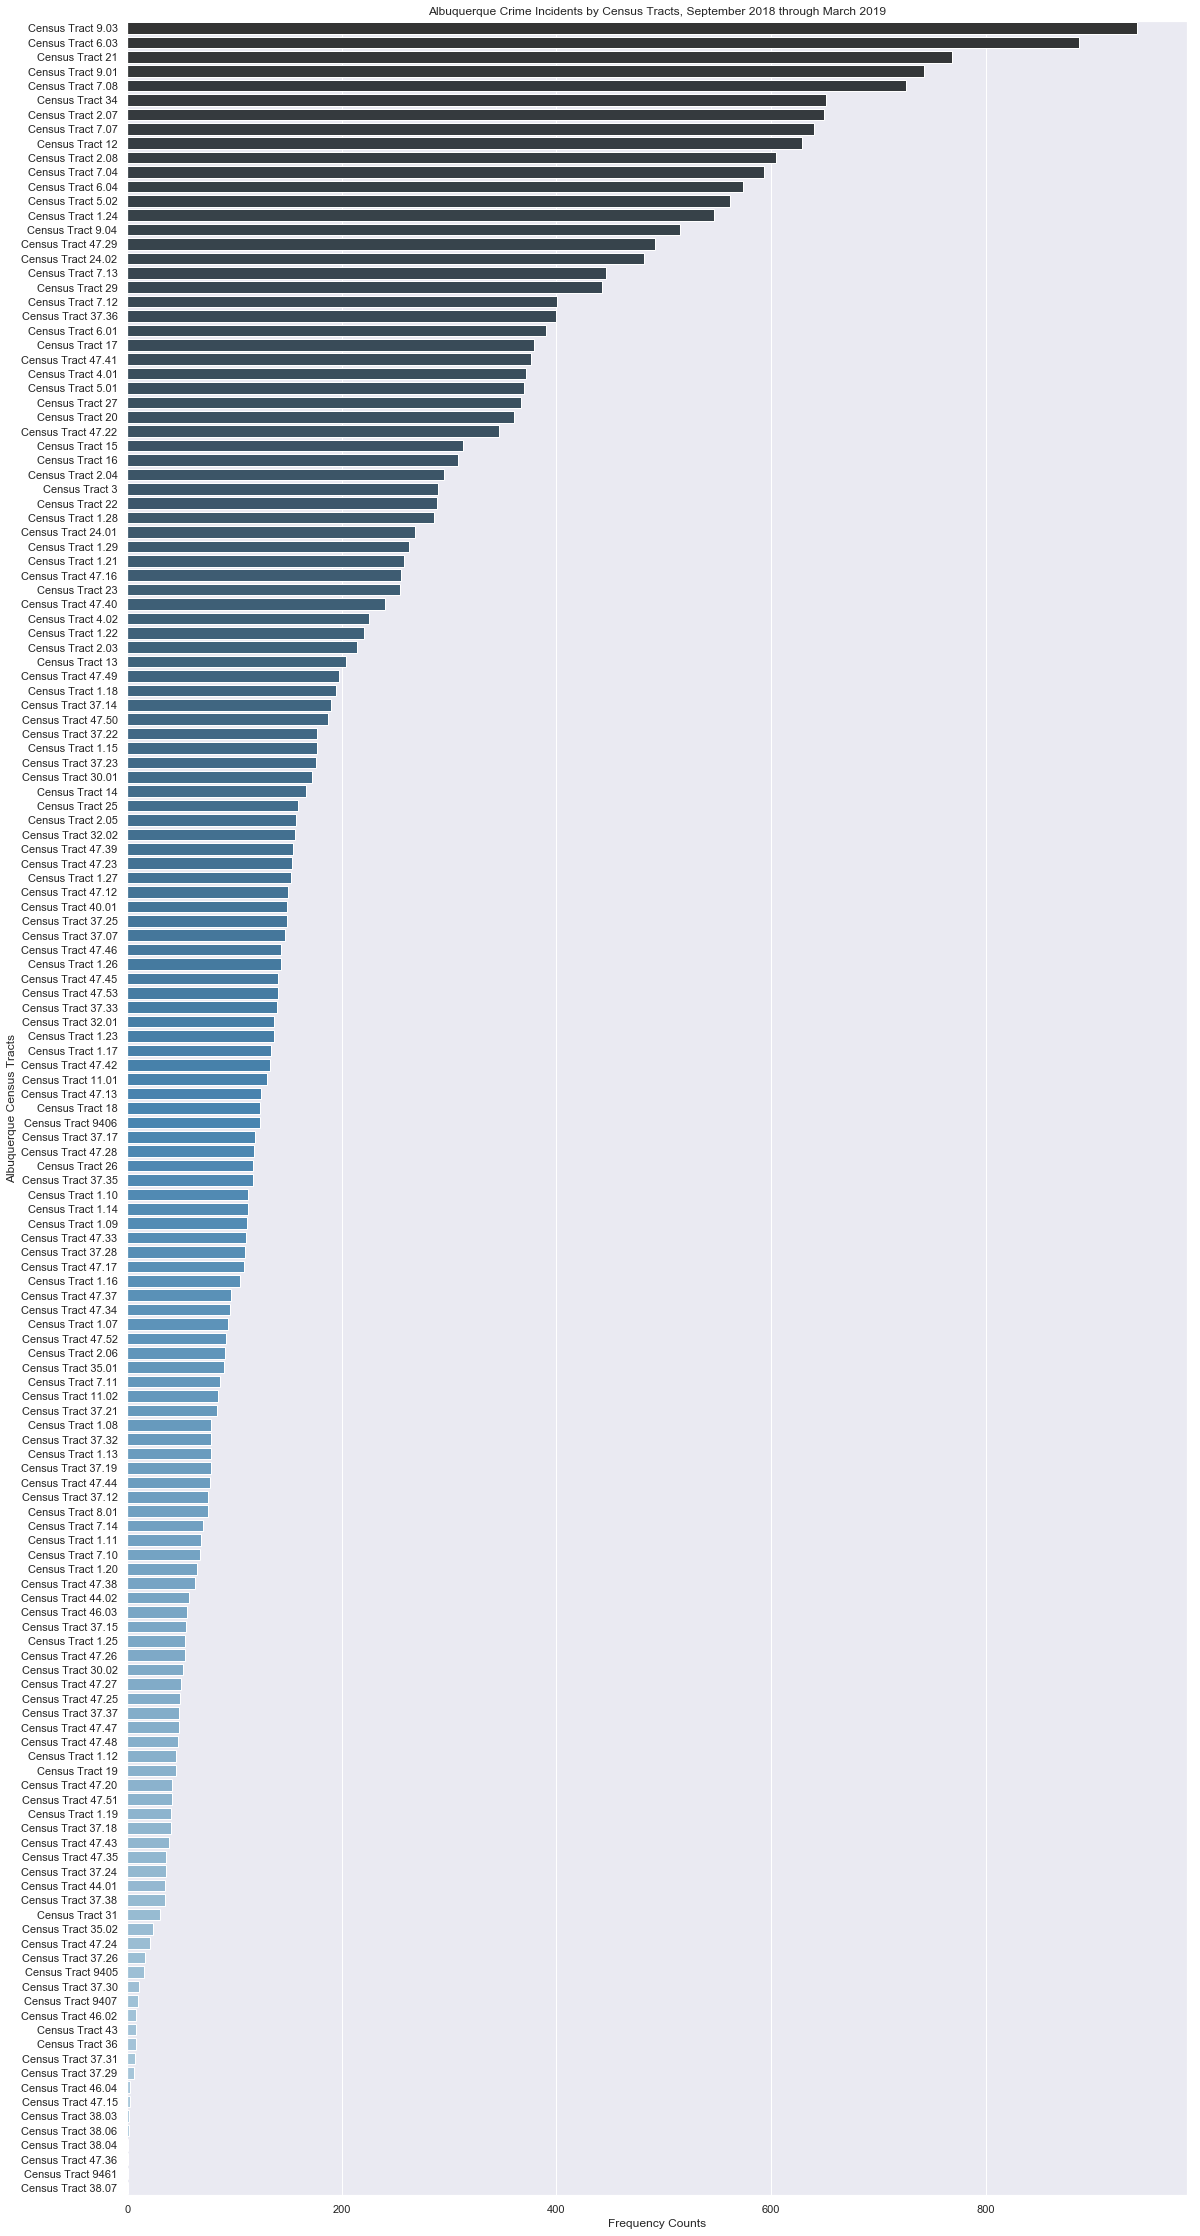

In [677]:
sns.set(style="darkgrid", )
plt.figure(figsize=(19,40))
sns.countplot(y="CENSUS_TRACT", data=incidents,
                 palette="Blues_d",order = incidents['CENSUS_TRACT'].value_counts().index)
plt.xlabel("Frequency Counts")
plt.ylabel("Albuquerque Census Tracts")
plt.title("Albuquerque Crime Incidents by Census Tracts, September 2018 through March 2019") 
plt.show()

#### Heatmap of Albuquerque Incidents

Next, we will visualize the density of incidents per census tracts in Albuquerque. The darker shared areas are the census tracts that have reported higher incidents. The map below is interactive. [The link to the map is here](https://arcg.is/1849zD)

In [678]:
display(HTML('<h1><style>.embed-container {position: relative; padding-bottom: 64%; height: 0; max-width: 100%;} .embed-container iframe, .embed-container object, .embed-container iframe{position: absolute; top: 0; left: 0; width: 100%; height: 100%;} small{position: absolute; z-index: 40; bottom: 0; margin-bottom: -15px;}</style><div class="embed-container"><iframe width="940" height="600" frameborder="0" scrolling="no" marginheight="0" marginwidth="0" title="Albuquerque Incidents by Census Tract" src="//abq.maps.arcgis.com/apps/Embed/index.html?webmap=e3731f08a68d4b2b87db6b2c04e5cf7a&extent=-107.1804,34.826,-106.1662,35.2908&zoom=true&previewImage=true&scale=false&details=true&legend=true&active_panel=legend&disable_scroll=true&theme=dark"></iframe></div></h1>'))

#### Feature Observation

Just to recap, we are using two features from the Albuquerque incidents dataset: '`MED_AGE`', and '`MED_INCOME`'. Each data point has been associated with their proper census tract along with incidents ('`COUNTS`'):

- '`MED_AGE`' is the median age of individuals residing in a particular census tract.

- '`MED_INCOME`' is the median income of individuals residing in a particular census tract.

'`MED_AGE`': An increase in the value of this feature will likely decrease the value of 'COUNTS' given that the increase in an individual's age often associated with an increase in resources and stability. Along with an increase in resources there may be an association of affording the means to live in more affluent and neighborhoods less affected by crime. 

'`MED_INCOME`': An increase in the value of this feature will likely decrease the value of 'COUNTS'; due to those earning less income would not likely be able to afford homes and apartments that are located in census tracts less affected by crime. 

Below, we are testing our initial intuition-the scatterplots below will give more insight. 

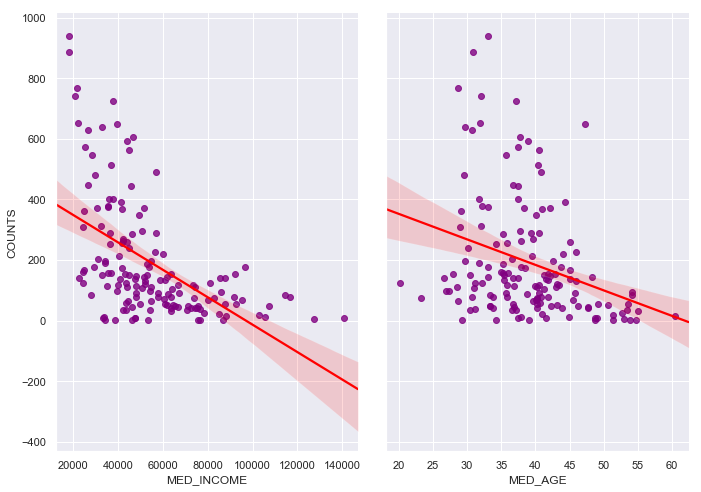

In [679]:
sns.pairplot(crime_counts, x_vars=['MED_INCOME', 'MED_AGE'], y_vars='COUNTS', size=7, aspect=0.7, kind='reg',plot_kws={'scatter_kws':{"color": "purple"},'line_kws':{'color':'red'}})
plt.show()

The scatter plots above confirm the initial intuition about the the relationship between features.

### Developing a Model 
In this portion of the project, we will develop the tools and techniques necessary for a model to make a prediction regarding incidents. We are looking to make accurate evaluations of each model's performance through the use of these tools and techniques.

#### Define a Performance Metric
For this project, we will be calculating the [*coefficient of determination*](http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination), R<sup>2</sup>, to measure the performance of the model. 
The coefficient of determination for a model is a useful statistic in regression analysis, as it often describes how "good" that model is at making predictions. 

The values for R<sup>2</sup> range from 0 to 1, which captures the percentage of squared correlation between the predicted and actual values of the **target variable**. A model with an R<sup>2</sup> of 0 is no better than a model that always predicts the *mean* of the target variable, whereas a model with an R<sup>2</sup> of 1 perfectly predicts the target variable. Any value between 0 and 1 indicates what percentage of the target variable, using this model, can be explained by the **features**. 

Below we will define a function that returns the r2 score for given true and predicted data.

In [680]:
# Import 'r2_score'
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

#### Goodness of Fit
Assume that a dataset contains six data points and a model made the following predictions for the target variable:

| True Value | Prediction |
| :-------------: | :--------: |
| 5.0 | 3.5 |
| -1.5 | 1.0 |
| 6.0 | 9.1 |
| 2.0 | 8.8 |
| 8.2 | 3.3 |
| 3.2 | 4.3 |

Below the model's coefficient of determination is calculated. 

In [681]:
# Calculate the performance of this model
score = performance_metric([5, -1.5, 6, 2, 8.2, 3.2], [3.5, 1.0, 9.1, 8.8, 3.3, 4.3])
print("Model has a coefficient of determination, R^2, of {:.3f}.".format(score))

Model has a coefficient of determination, R^2, of -0.562.


This model has successfully captured the variation of the target variable with a coefficient of determination, (R2), of -0.562, or -56.2%. The best outcome is a score of 1, and the least favorable is a score of zero, so this outcome is poor. s

#### Shuffle and Split Data
Next, this dataset will be split the data into training and testing subsets. The data will also be shuffled into a random order when creating the training and testing subsets to remove any bias in the ordering of the dataset.

Splitting a dataset into testing and training subsets allows for the data to properly train then evaluate the performance on new data (testing). It is important to use both a training and testing set in order to evaluate the true performance of the model on unseen data to avoid issues such as overfitting, which is the model may do very well on training, but poorly on testing since the model simply memorized the seen data. Another issue in failing to use testing and training subsets is underfitting, which is the model does poorly on both the training and testing sets.

In [682]:
# Import 'train_test_split'
from sklearn.model_selection import train_test_split 

# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features,number_per_tract,test_size=0.2,random_state=90)

#transpose
y_train=y_train.transpose()

#Change datatypes to float
X_train=X_train.astype(float)
y_train=y_train.astype(float)

# Show the results of the split
print("Training set has {} samples.".format(X1_train.shape[0]))
print("Testing set has {} samples.".format(X1_test.shape[0]))

Training set has 121 samples.
Testing set has 31 samples.


### Analyzing Model Performance
In this next section, we will investigate two models and determine which is best at modeling the data.

Here are the models we will test:

**Linear Regression**

- Strengths:
    
Linear regression is known to be a fast algorithm, that is less susceptible to overfitting. The model is typically easy to understand. 
    
- Weaknesses:

 It is difficult to model complex relationships and presumes a linear relationship between variables. 


**Decision Tree**

- Strengths:

  Able to handle categorical and numerical data.
  Doesn’t require extensive data pre-processing, and can handle data which has not been normalized, or encoded for Machine 
  Learning Suitability. 
  
  
- Weaknesses:

  Complex Decision Trees do not generalize well to the data and can result in overfitting.
  Unstable, as small variations in the data can result in a different decision tree. This is why they are usually used in an ensemble (Random Forests) to build robustness.
    Can create biased trees if some classes dominate others.


#### Linear Regression

In [683]:
# import model
from sklearn.linear_model import LinearRegression

# Initialize
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [684]:
# Intercepts and coefficients
print(linreg.intercept_)
print(linreg.coef_)

352.40928368039863
[ 0.87692642 -0.00380286]


In [685]:
# pair the feature names with the coefficients
zip(features, linreg.coef_)

In [686]:
# predictions on the testing set
y_pred = linreg.predict(X_test)

In [687]:
y_test = np.array(list(y_test))
y_pred = np.array(y_pred)
df= pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df.head()

,Actual,Predicted
0,35,219.492158
1,137,210.866400
2,221,162.872019
3,36,219.256395
4,640,253.077457


#### Linear Regression Performance

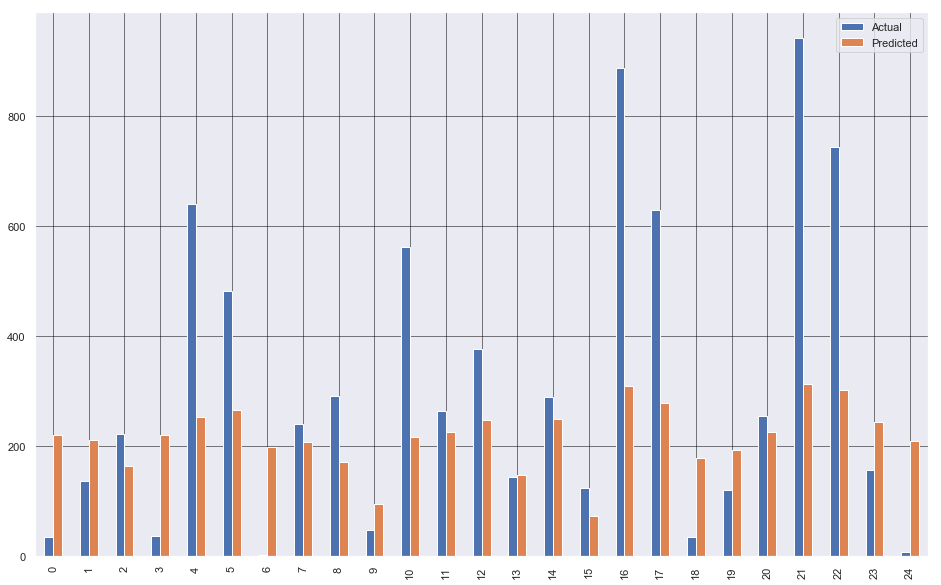

In [688]:
df1 = df.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

It does not appear that this model is very precise and there is a discrepancy between the actual and predicted values. Based upon these findings, we will not proceed with a linear regression model and will utilize a decision tree model. 

#### Decision Tree

In [689]:
# Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

def fit_model(X, y):
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits = 5, test_size = 0.20, random_state = 0)

    # Create a decision tree regressor object
    regressor = DecisionTreeRegressor()

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth': range(1,11)}

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_func = make_scorer(performance_metric)

    # Create the grid search cv object --> GridSearchCV()
    # Make sure to include the right parameters in the object:
    # (estimator, param_grid, scoring, cv) which have values 'regressor', 'params', 'scoring_fnc', and 'cv_sets' respectively.
    grid = GridSearchCV(regressor,params,scoring_func,cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [690]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth']))

Parameter 'max_depth' is 2 for the optimal model.


#### Predicting crime counts in Albuquerque
Let us imagine that we are evaluating crime counts per census tract based upon income and age. This is a fictional evaluation of what to expect. 

| Feature| TRACT 1 | TRACT 2 | TRACT 3 || TRACT 4 || TRACT 5 ||
| :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| MED_INCOME | 35,000 | 18,000 | 90,000 |41,000|51,000|
| MED_AGE| 40 | 31 | 70|18|22|


In [691]:
# Produce a matrix for crime data
crime_predictions=[[40, 35000], # TRACT 1
                   [31, 18000], # TRACT 2
                   [70, 90000], # TRACT 3
                   [18, 41000],  # TRACT 4
                   [22, 51000]] # TRACT 5

# Show predictions
for i, count in enumerate(reg.predict(crime_predictions)):
    print("Predicted number of incident counts for census tract {}: {:,.0f}".format(i+1, count))

Predicted number of incident counts for census tract 1: 259
Predicted number of incident counts for census tract 2: 710
Predicted number of incident counts for census tract 3: 68
Predicted number of incident counts for census tract 4: 259
Predicted number of incident counts for census tract 5: 158


In [692]:
#Create a trial function 
def PredictTrials(X, y, fitter, data):
    """ Performs trials of fitting and predicting data. """

    # Store the predicted counts
    number_per_tract= []

    for k in range(25):
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, \
            test_size = 0.2, random_state = k)

        # Fit the data
        reg = fitter(X_train, y_train)

        # Make a prediction
        pred = reg.predict([data[0]])[0]
        number_per_tract.append(pred)

        # Result
        print("Trial {}: {:,.0f}".format(k+1, pred))

    # Display a range
    print("\nRange in counts: {:,.0f}".format(max(number_per_tract) - min(number_per_tract)))


In [693]:
#predict the counts
PredictTrials(features, number_per_tract, fit_model, crime_predictions)

Trial 1: 274
Trial 2: 267
Trial 3: 353
Trial 4: 264
Trial 5: 277
Trial 6: 243
Trial 7: 201
Trial 8: 214
Trial 9: 252
Trial 10: 260
Trial 11: 294
Trial 12: 280
Trial 13: 233
Trial 14: 290
Trial 15: 272
Trial 16: 271
Trial 17: 261
Trial 18: 283
Trial 19: 274
Trial 20: 265
Trial 21: 285
Trial 22: 270
Trial 23: 259
Trial 24: 238
Trial 25: 246

Range in counts: 153


### Conclusion

- There is an obvious association between income and the number of incidents a census tract will experience. 

- The data reflects what incident counts would be expected in Albuquerque in census tracts that earn less than a certain income. The median income of a large percentage of the census tracts are under $55,000 a year. 

- Given the model and the data points associated with it, this model is not robust enough to make an accurate prediction. Each census tract was associated with a median income and median age, therefore not allowing for a range in values that would result in better prediction. 

- With an accurate model and significantly more data points each associated with a unique value, a model of this nature would not only aid law enforcement, but potential homebuyers in deciding where to reside. 
